# Add interesting quasars to prior list and run XID+ at those positions

The original sample and subsample are described here:

Pitchford+16: https://ui.adsabs.harvard.edu/abs/2016AAS...22743804P/abstract

Hatziminaoglou+18: https://ui.adsabs.harvard.edu/abs/2018MNRAS.480.4974H/abstract

In [1]:
import pyvo as vo
import glob
import time
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import yaml

from astropy.coordinates import SkyCoord
from astropy import units as u

from astropy.table import Table, Column, vstack, join

from herschelhelp_internal.utils import inMoc, gen_help_id

from pymoc import MOC

In [2]:
qsos = Table.read('./data/ACA_sources_forExtraction_RShirley_070619.fits')
dmu_loc="/Users/rs548/GitHub/dmu_products/"

In [3]:
qsos

RA_SDSS,DEC_SDSS,RA_ALMA,Dec_ALMA
hms,dms,hms,dms
bytes11,bytes11,bytes11,bytes11
00:07:46.93,+00:15:43.0,00:07:46.93,+00:15:42.9
00:11:21.87,-00:09:18.6,00:11:21.98,-00:09:19.6
00:14:01.09,-01:06:07.2,00:14:01.11,-01:06:07.0
00:30:11.77,+00:47:50.0,00:30:11.77,+00:47:50.1
00:30:11.77,+00:47:50.0,00:30:11.45,+00:47:48.0
00:30:11.77,+00:47:50.0,00:30:11.70,+00:48:00.3
00:44:40.50,+01:03:06.4,00:44:40.48,+01:03:06.7
01:03:15.69,+00:35:24.2,01:03:15.69,+00:35:24.1


First lets see where these are on the sky

In [4]:
#convert coords from sexigesimal to decimal degrees
coords = SkyCoord([ra[:2] + 'h' + ra[3:5] + 'm' + ra[6:] + 's' for ra in qsos['RA_SDSS'].astype(str)], 
         [dec[:3] + 'd' + dec[4:6] + 'm' + dec[7:] + 's' for dec in qsos['DEC_SDSS'].astype(str)])
ra = coords.ra.degree
dec = coords.dec.degree

In [5]:
qsos.add_column(Column(data=ra, name='sdss_ra', unit=u.deg))
qsos.add_column(Column(data=dec, name='sdss_dec', unit=u.deg))

In [6]:
#convert coords from sexigesimal to decimal degrees
alma_coords = SkyCoord([ra[:2] + 'h' + ra[3:5] + 'm' + ra[6:] + 's' for ra in qsos['RA_ALMA'].astype(str)], 
         [dec[:3] + 'd' + dec[4:6] + 'm' + dec[7:] + 's' for dec in qsos['Dec_ALMA'].astype(str)])
alma_ra = alma_coords.ra.degree
alma_dec = alma_coords.dec.degree

In [7]:
qsos.add_column(Column(data=alma_ra, name='alma_ra', unit=u.deg))
qsos.add_column(Column(data=alma_dec, name='alma_dec', unit=u.deg))

In [8]:
qsos.add_column(Column(gen_help_id(qsos['sdss_ra'], qsos['sdss_dec']),
                                   name="temp_id"))
qsos.add_column(Column(gen_help_id(qsos['alma_ra'], qsos['alma_dec']),
                                   name="alma_id"))

In [10]:
qsos.add_column(Column(
    data=[np.sum(qsos['temp_id'] == gal['temp_id']) for gal in qsos],
    name='multiplicity'))

In [12]:
qsos[:10]

RA_SDSS,DEC_SDSS,RA_ALMA,Dec_ALMA,sdss_ra,sdss_dec,alma_ra,alma_dec,temp_id,alma_id,multiplicity
hms,dms,hms,dms,deg,deg,deg,deg,,,
bytes11,bytes11,bytes11,bytes11,float64,float64,float64,float64,bytes27,bytes27,int64
00:07:46.93,+00:15:43.0,00:07:46.93,+00:15:42.9,1.9455416666666665,0.2619444444444444,1.9455416666666665,0.2619166666666667,HELP_J000746.930+001543.000,HELP_J000746.930+001542.900,1
00:11:21.87,-00:09:18.6,00:11:21.98,-00:09:19.6,2.8411249999999995,-0.15516666666666667,2.841583333333333,-0.15544444444444444,HELP_J001121.870-000918.600,HELP_J001121.980-000919.600,1
00:14:01.09,-01:06:07.2,00:14:01.11,-01:06:07.0,3.5045416666666664,-1.102,3.5046249999999994,-1.1019444444444446,HELP_J001401.090-010607.200,HELP_J001401.110-010607.000,1
00:30:11.77,+00:47:50.0,00:30:11.77,+00:47:50.1,7.549041666666666,0.7972222222222222,7.549041666666666,0.79725,HELP_J003011.770+004750.000,HELP_J003011.770+004750.100,3
00:30:11.77,+00:47:50.0,00:30:11.45,+00:47:48.0,7.549041666666666,0.7972222222222222,7.547708333333332,0.7966666666666666,HELP_J003011.770+004750.000,HELP_J003011.450+004748.000,3
00:30:11.77,+00:47:50.0,00:30:11.70,+00:48:00.3,7.549041666666666,0.7972222222222222,7.548749999999998,0.8000833333333334,HELP_J003011.770+004750.000,HELP_J003011.700+004800.300,3
00:44:40.50,+01:03:06.4,00:44:40.48,+01:03:06.7,11.168749999999998,1.051777777777778,11.168666666666663,1.0518611111111111,HELP_J004440.500+010306.400,HELP_J004440.480+010306.700,1
01:03:15.69,+00:35:24.2,01:03:15.69,+00:35:24.1,15.815374999999998,0.5900555555555556,15.815374999999998,0.5900277777777778,HELP_J010315.690+003524.200,HELP_J010315.690+003524.100,1


In [11]:
qsos.write('./data/qsos.fits', overwrite=True)

In [12]:
def get_herschel_fields(ra, dec,
                       dmu_loc="/Users/rs548/GitHub/dmu_products/"):
    """Take an array of ra, dec positions and get HELP field names"""
    fields = Column(np.full(len(ra), "not_help", dtype='<U18'),
                                   name="field")
    help_fields = yaml.load(open(dmu_loc + "dmu2/meta_main.yml", 'r'))['fields']
    for f in help_fields:
        f_moc = MOC(filename=dmu_loc + f['region'].replace('dmu_products/', ''))
        fields[inMoc(ra, dec, f_moc)] = f['name']
    print("Objects on {}".format(np.unique(fields)))
    return fields

fields = get_herschel_fields(ra, dec)


Objects on       field       
------------------
Herschel-Stripe-82


/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


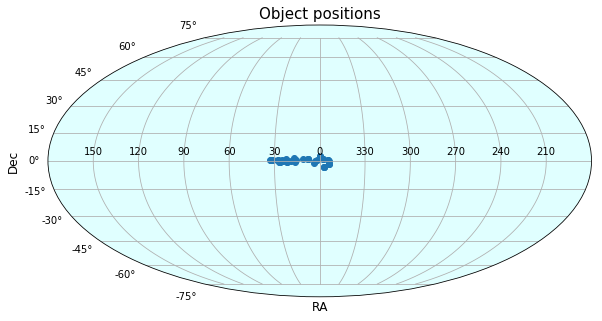

In [13]:
def plot_mwd(RA,Dec,org=0,title='Object positions', projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection, axisbg ='LightCyan')
    ax.scatter(np.radians(x),np.radians(Dec))  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
plot_mwd(coords.ra.degree, coords.dec.degree)

In [14]:
shela_moc = MOC(filename = dmu_loc + 'dmu0/dmu0_SHELA/survey_coverage_MOC.fits')
spies_moc = MOC(filename = dmu_loc + 'dmu0/dmu0_SpIES/survey_coverage_MOC.fits')

In [15]:
np.sum(inMoc(ra, dec, shela_moc))

13

In [16]:
np.sum(inMoc(ra, dec, spies_moc))

20

In [17]:
np.sum(inMoc(ra, dec, shela_moc) & inMoc(ra, dec, spies_moc))

1

In [18]:
len(ra)

40

 The following shows the SHELA region (yellow) and SpIES region (blue) from Alladin. These are both quite shallow. 
 
 ![The objects over SHELA and SpIES coverage](./figs/shela_spies_Hatziminaoglou.png)
 
 Now lets get all the IRAC objects within 100 arcsec of the qsos

In [19]:

cross_query = """
SELECT 
*
FROM herschelhelp.main AS db
JOIN TAP_UPLOAD.t1 AS tc
ON 1=CONTAINS(POINT('ICRS', db.ra, db.dec),
CIRCLE('ICRS', tc.RA, tc.DEC, 1./3600.))
WHERE db.f_irac_i1 IS NOT NULL"""

# construct a service; I’ve taken the URL from TOPCAT’s
# TAP service browser # ("Selected TAP Service" near the
# foot of the dialog)
service = vo.dal.TAPService(
          "https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap")

In [20]:
pos = Table()
pos.add_column(Column(data=ra, name='ra'))
pos.add_column(Column(data=dec, name='dec'))

In [21]:
job = service.submit_job(cross_query,
                          uploads = {'t1': pos})
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
while job.phase == 'EXECUTING':
    print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(10) #wait ten seconds and try again

print(job.phase)
result = job_result.fetch_result()

Job still running after 0 seconds.
COMPLETED


In [22]:
help_objects = result.table
help_objects.show_in_notebook()

In [23]:
help_objects['f_irac_i1']

136.95592975495
418.769515007016
40.9362791639893
40.9362791639893
40.9362791639893
60.4840431213379
58.1669616699219
41.439697265625
317.861602783203
317.861602783203
43.4624328613281


In [24]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read
    
    Inputs
    =======
    table
    
    Returns
    =======
    table
    
    """
    table = table.copy()
    for col in table.colnames:
        if np.all(table[col].mask):
            table.remove_column(col)
    for col in table.colnames:
        if table[col].dtype == 'object':
            print(col, table[col].dtype )
        
            table[col] = table[col].astype(str)
    return table
help_objects = clean_table(help_objects)
help_objects.write('./data/help_objects_matched_qsos.fits', overwrite=True)

field object
help_id object
stellarity_origin object


A lot of the objects appear to be irac 1 sources.

In [25]:
circle_query = """
SELECT 
*
FROM herschelhelp.main AS db
JOIN TAP_UPLOAD.t1 AS tc
ON 1=CONTAINS(POINT('ICRS', db.ra, db.dec),
CIRCLE('ICRS', tc.RA, tc.DEC, 100./3600.))
WHERE db.f_irac_i1 IS NOT NULL"""

job = service.submit_job(circle_query,
                          uploads = {'t1': pos})
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
while job.phase == 'EXECUTING':
    print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(10) #wait ten seconds and try again

print(job.phase)
result = job_result.fetch_result()

Job still running after 0 seconds.
COMPLETED


In [26]:
near_objects = result.table
len(near_objects)

4280

In [27]:
near_objects[:10].show_in_notebook()

In [28]:
near_objects = clean_table(near_objects)
near_objects.write('./data/help_preselection_priors.fits', overwrite=True)

field object
help_id object
stellarity_origin object


# Make images
The full HS82 images are too large to load into memory. We start by making cutouts to make subsequent stages faster.

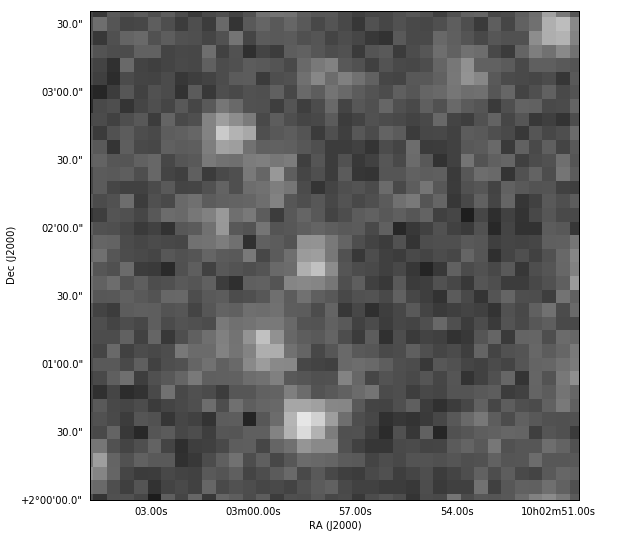

In [29]:
#Folder containing maps
import xidplus
import aplpy
imfolder=xidplus.__path__[0]+'/../test_files/'

cosmos_test=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PSW_hipe.fits.gz'#SPIRE 250 map


test_ra=[150.74]*u.degree 
test_dec=[2.03]*u.degree

gc = aplpy.FITSFigure(cosmos_test)
gc.show_grayscale(vmin=-2e-2, vmax = 4e-2)
gc.recenter(test_ra, test_dec, radius=0.03)

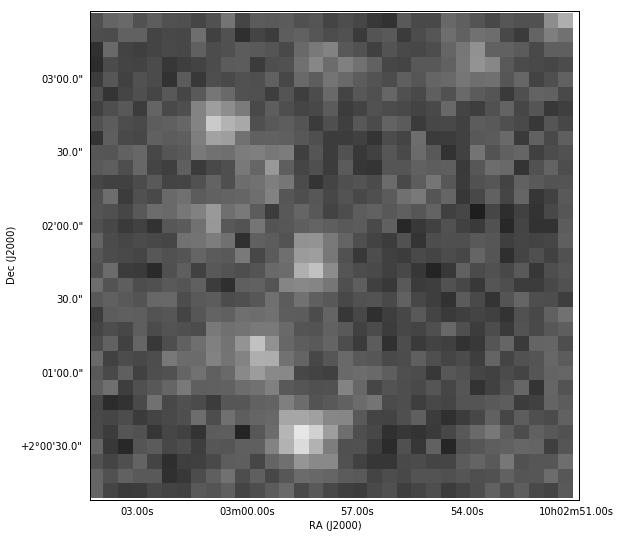

In [30]:
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, Angle


def cut_out(original, ra, dec, target, size_angle=100*u.arcsec):
    """Take an input image and cutout a square around the centre and save the new file to the target"""
    original_fits = fits.open(original)
    primary_hdu = original_fits[0]
    image_hdu = original_fits[1]
    noise_hdu = original_fits[2]
    image_wcs = WCS(image_hdu.header)
    noise_wcs = WCS(noise_hdu.header)
    
   # Make the cutout, including the WCS
    ra_dec_position = SkyCoord(ra, dec, frame='icrs')
    x_y_position = skycoord_to_pixel(ra_dec_position, image_wcs)
    size_pix = 2*(Angle(size_angle).degree/Angle(original_fits[1].header['CD2_2']*u.deg ).degree )*  u.pixel
    image_cutout = Cutout2D(image_hdu.data, position=x_y_position, size=size_pix, wcs=image_wcs)
    noise_cutout = Cutout2D(noise_hdu.data, position=x_y_position, size=size_pix, wcs=noise_wcs)

    # Put the cutout image in the FITS HDU
    image_hdu.data = image_cutout.data
    noise_hdu.data = noise_cutout.data

    # Update the FITS header with the cutout WCS
    image_hdu.header.update(image_cutout.wcs.to_header())
    noise_hdu.header.update(noise_cutout.wcs.to_header())

    # Write the cutout to a new FITS file
    
    hdu_list = fits.HDUList([primary_hdu, image_hdu, noise_hdu])
    
    hdu_list.writeto(target, overwrite=True)
    hdu_list.close()
    return target , image_hdu.data, noise_hdu.data
    
loc, im, n = cut_out(cosmos_test, test_ra, test_dec, './data/test_cosmos.fits')

gc = aplpy.FITSFigure(loc)
gc.show_grayscale(vmin=-2e-2, vmax = 4e-2)
gc.recenter(test_ra, test_dec, radius=Angle( 100*u.arcsec).degree)

In [34]:
for gal in qsos:
    print(gal['sdss_ra'], gal['sdss_dec'], gal['temp_id'])
    for band in [250, 350, 500]:
        loc = cut_out('/Users/rs548/GitHub/dmu_products/'
                     + 'dmu19/dmu19_HELP-SPIRE-maps/data/Herschel-Stripe-82_SPIRE{}_v0.9.fits'.format(band), 
                  gal['sdss_ra']*u.deg, gal['sdss_dec']*u.deg, 
                  './data/cuts/{}_cut_{}.fits'.format(gal['temp_id'], band))
    

1.9455416666666665 0.2619444444444444 HELP_J000746.930+001543.000
2.8411249999999995 -0.15516666666666667 HELP_J001121.870-000918.600
3.5045416666666664 -1.102 HELP_J001401.090-010607.200
7.549041666666666 0.7972222222222222 HELP_J003011.770+004750.000
7.549041666666666 0.7972222222222222 HELP_J003011.770+004750.000
7.549041666666666 0.7972222222222222 HELP_J003011.770+004750.000
11.168749999999998 1.051777777777778 HELP_J004440.500+010306.400
15.815374999999998 0.5900555555555556 HELP_J010315.690+003524.200
16.351666666666663 -0.4241944444444445 HELP_J010524.400-002527.100
16.968833333333333 1.3936111111111111 HELP_J010752.520+012337.000
19.289875 0.08997222222222222 HELP_J011709.570+000523.900
21.752874999999996 -0.7664444444444445 HELP_J012700.690-004559.200
21.752874999999996 -0.7664444444444445 HELP_J012700.690-004559.200
22.151583333333335 0.8259444444444445 HELP_J012836.380+004933.400
22.191625 0.64525 HELP_J012845.990+003842.900
24.56058333333333 0.0009722222222222222 HELP_J013

#